1. В коде из методички реализуйте один или несколько из критериев останова (количество листьев, количество используемых признаков, глубина дерева и т.д.).
2. Для задачи классификации обучить дерево решений с использованием критериев разбиения Джини и Энтропия. Сравнить качество классификации, сделать выводы. 


**Задание 1 и 2 перекликаются, поэтому релизация сделана по расположению функций в методичке. Комментарии сделаны жирным в текстовом блоке и большими буквами в коде**

In [ ]:
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn import datasets

import numpy as np

In [ ]:
# сгенерируем данные
classification_data, classification_labels = datasets.make_classification(n_features = 2, n_informative = 2, 
                                                      n_classes = 2, n_redundant=0, 
                                                      n_clusters_per_class=1, random_state=5)

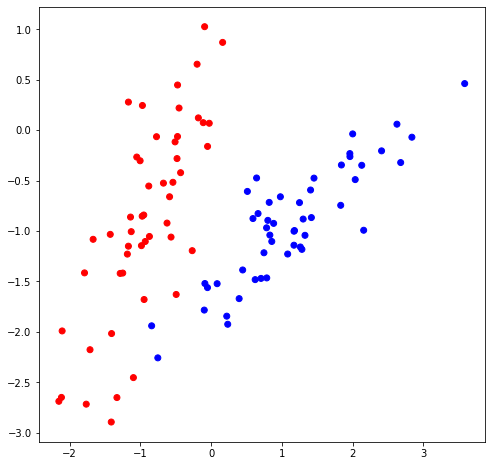

In [ ]:
# визуализируем сгенерированные данные

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors)

In [ ]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [ ]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction        

In [ ]:
# Расчет критерия Джини

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

In [ ]:
# Расчет качества

def quality(left_labels, right_labels, current_gini):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

**Создадим функцию для расчет энтропии**

In [ ]:
# Расчет Энтропии

def entropy(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p*np.log2(p) # МЕНЯЕМ ПО ФОРМУЛЕ
        
    return impurity

In [200]:
# Расчет качества энтропии

def quality_entropy(left_labels, right_labels, current_entropy):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_entropy - p * entropy(left_labels) - (1 - p) * entropy(right_labels)

In [201]:
# Разбиение датасета в узле

def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [208]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf = 5
    deap = 0 # ДОБАВИМ ГЛУБИНУ ДЕРЕВА. ДОБАВЛЯТЬ ЛИСТЬЯ, ПОЛАГАЮ, НЕ СТОИТ, ТАК КАК СУДЯ ПО ЛЕКЦИИ, ПРИ БИНАРНОМ РАЗДЕЛЕНИИ КОЛИЧЕСТВО ЛИСТЬЕВ РАВНО ГЛУБИНЕ -1
    current_gini = gini(labels)
    current_entropy = entropy(labels)

    
    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    count_index = n_features
    
    print(count_index)

    for index in range(n_features):
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            deap += 1
            
            current_quality_gini = quality(true_labels, false_labels, current_gini)                             #ВЫВЕДЕМ НА ПЕЧАТЬ КРИТЕРИЙ ДЖИНИ
            print(f'Критерий Джини {current_quality_gini}')

            current_quality_intropy = quality_entropy(true_labels, false_labels, current_entropy)                #ВЫВЕДЕМ НА ПЕЧАТЬ ЭНТРОПИЮ
            print(f'Энтропия {current_quality_intropy}')

            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality_gini > best_quality:
                best_quality, best_t, best_index = current_quality_gini, t, index
            print(f'Глубина - {deap}')
            print(f'количество признаков - {count_index}')
    return best_quality, best_t, best_index, deap, count_index

**Из методички: В def build_tree реализовано останова при отсутствии прироста в качестве. Сюда же добавим глубину и количество признаков. Deap возращается в функции find_best_split**

In [227]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels, min_index=0, max_deap=20000):


    quality, t, index, deap, count_index = find_best_split(data, labels)
    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0 or deap >= max_deap or count_index <= min_index:                       # ДОБАВИМ УСЛОВИЕ, ЧТО ГЛУБИНА НЕ ДОЛЖНА ПРЕВЫШАТЬ ОПРЕДЕЛЕННОГО ЧИСЛА, А ТАК ЖЕ ДОЛЖНО БЫТЬ КОЛИЧЕСТВО ПРИЗНАКОВ НЕ МЕНЕЕ УКАЗАННОГО
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [223]:
def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [224]:
def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [225]:
# Разобьем выборку на обучающую и тестовую

from sklearn import model_selection

train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data, 
                                                                                     classification_labels, 
                                                                                     test_size = 0.3,
                                                                                     random_state = 1)

In [228]:
# Построим дерево по обучающей выборке
my_tree = build_tree(train_data, train_labels)

2
Критерий Джини 0.038461538461538436
Энтропия 0.07539593734971195
Глубина - 1
количество признаков - 2
Критерий Джини 0.046875
Энтропия 0.09151934931104888
Глубина - 2
количество признаков - 2
Критерий Джини 0.05555555555555558
Энтропия 0.10803154614559984
Глубина - 3
количество признаков - 2
Критерий Джини 0.06451612903225823
Энтропия 0.12495281296430316
Глубина - 4
количество признаков - 2
Критерий Джини 0.07377049180327866
Энтропия 0.14230515247723075
Глубина - 5
количество признаков - 2
Критерий Джини 0.08333333333333343
Энтропия 0.16011249429901175
Глубина - 6
количество признаков - 2
Критерий Джини 0.09322033898305082
Энтропия 0.17840093854332806
Глубина - 7
количество признаков - 2
Критерий Джини 0.10344827586206895
Энтропия 0.1971990409283706
Глубина - 8
количество признаков - 2
Критерий Джини 0.11403508771929821
Энтропия 0.21653814851005837
Глубина - 9
количество признаков - 2
Критерий Джини 0.125
Энтропия 0.2364527976600279
Глубина - 10
количество признаков - 2
Критерий Джин

**Если правильно сделал формулу Энтропии, то у меня получается, что критерий Джини и Энтропия достигуют нуля на одной и то же глубине, а так же, по какой-то причине, сначала они растут, а потом начинают падать.**